<a href="https://colab.research.google.com/github/vedantpople4/AiProjects/blob/main/Follow_us_Exploring_dlt_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

# **Exploring `dlt` fundamentals by loading data to the filesystem destination**

In this workshop, we will:
- First, load data to DuckDB.
- Configure our pipeline to load data into the local filesystem instead of DuckDB.
- Learn how to use the filesystem destination as staging storage, using S3 as an example (covered in a separate Colab).


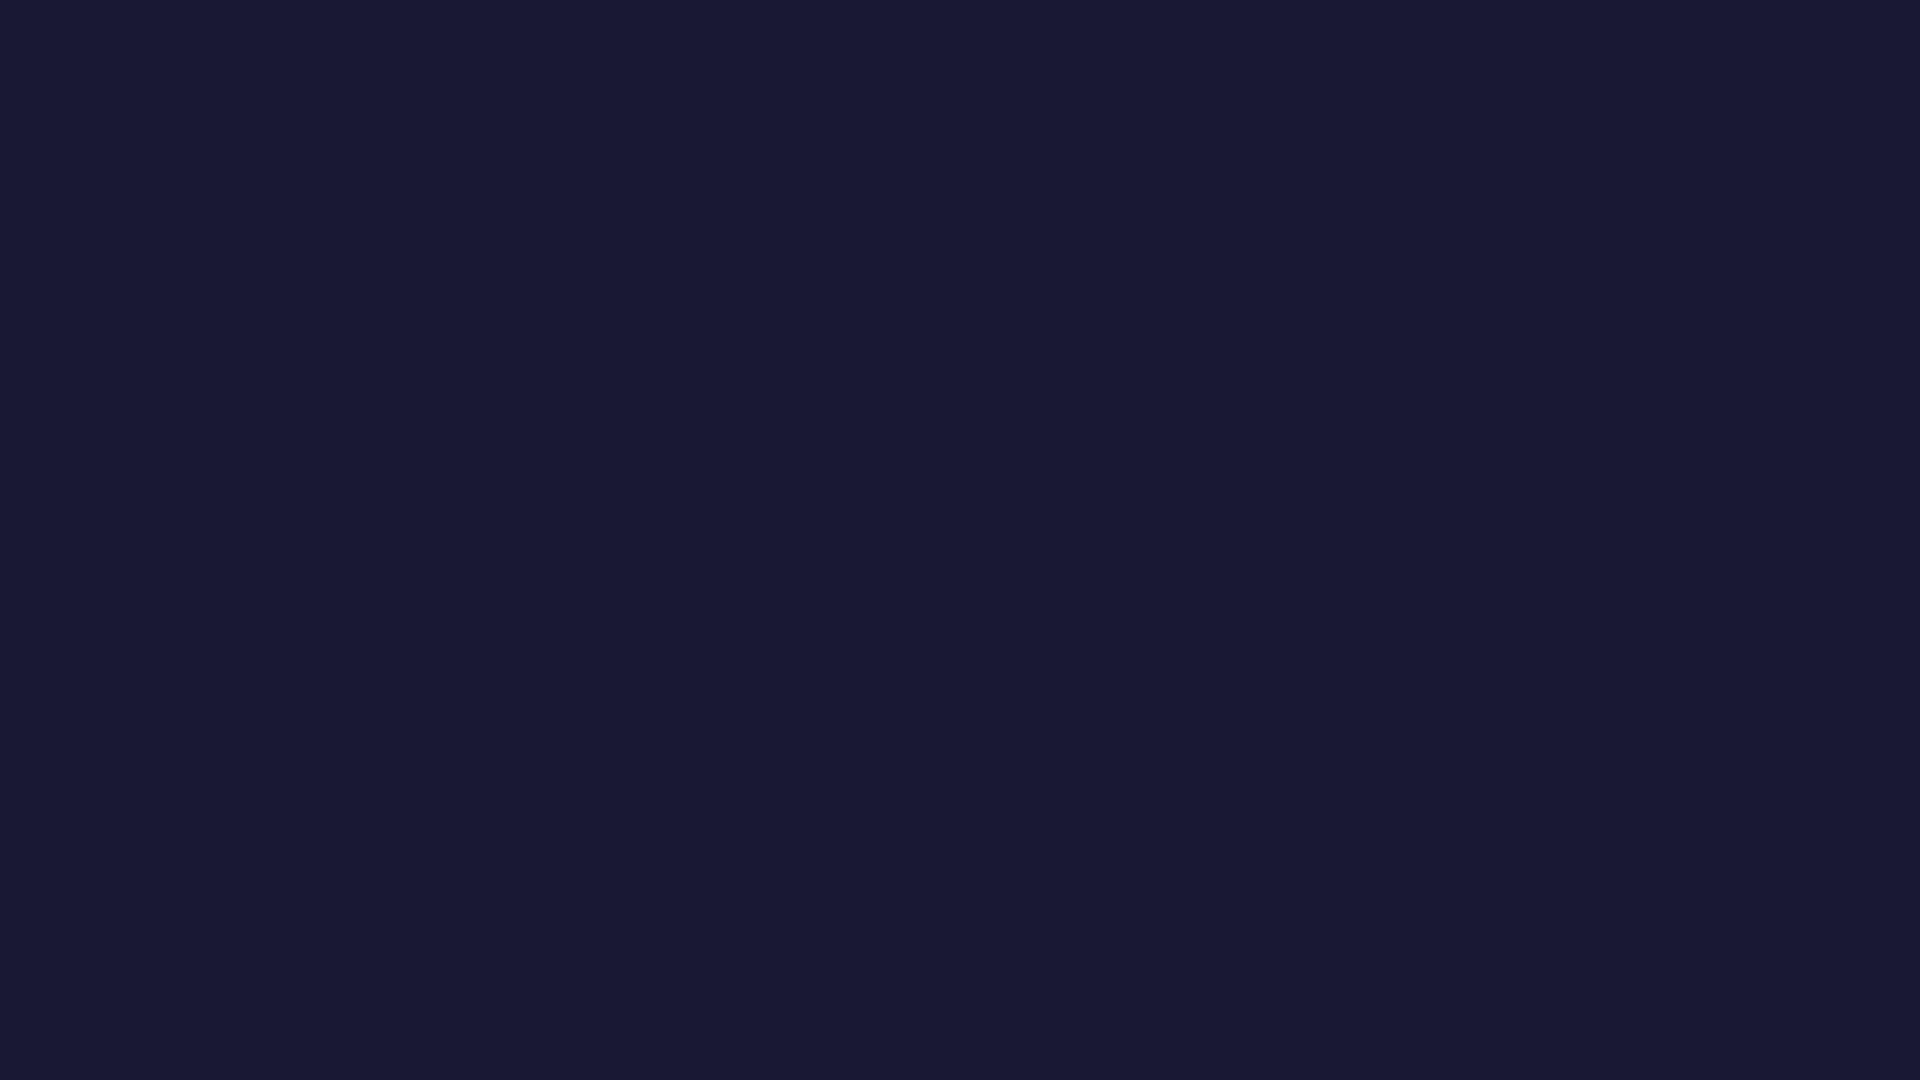

In the process, we will cover the following dlt fundamentals:
- [`Getting Started: dlt Resources and Sources`](https://colab.research.google.com/drive/1laas5XkGEQIqmpFX48pIL48-OoV_mEye)
- [`Defining Secrets and Configs`](https://colab.research.google.com/drive/11JW9efItqa31iQeQtABN6Qbc6RcQQMbW)
- [`Incremental Loading`](https://colab.research.google.com/drive/1izVY7a-CuRkV6rKok7Z8MNVIZ11PhMqN)
- [`Using dlt’s pre-built Sources and Destinations`](https://colab.research.google.com/drive/1Xig8yGmZ5gmbm_NjJ8mR1QMC1C5NUGPZ)
- [`dlt Destinations: Local Filesystem`](https://colab.research.google.com/drive/1jMW9RfFsvEZ54ehLJkeaEm6ViVaZs5sG#scrollTo=U36KX5VrWtWp)
- [`Staging`](https://colab.research.google.com/drive/1EeJoTkKcqB8-UnsS9cqTwbudo2YN6_Ne#scrollTo=tsFmu0Ezpfqu)
- [`Inspecting & Adjusting Schema`](https://colab.research.google.com/drive/1an46jq5wCv8jQrqShIN1xG45mr92ljor)
- [`Understanding Pipeline Metadata`](https://colab.research.google.com/drive/1ABHITE9BlXcN5pxzqIjIz_zcXY9EXlp0#scrollTo=l7Y1oCAvJ79I)


Let's dive in!

---

## **How to work in this workshop?**

The current Colab titled `Follow us: Exploring dlt Fundamentals` is the main Colab you'll be using. Throughout the Colab, there will be small sections where you'll need to fix or complete code to gain hands-on experience — these sections will explicitly begin with a **❗⚠️❗TODO**.

> If you haven't already, make a copy of this Colab to follow along. You'll also need a classic access token from GitHub.


As you progress, you'll encounter links to additional Colabs, each covering a different aspect of `dlt` fundamentals mentioned above. These will help you complete the tasks in this main Colab,  so follow them closely and pay careful attention to the explanations.

---
## **(A) Load data to DuckDB**

---
### **(0) Define your `dlt` source**

> Before diving in, refresh your knowledge by running a simple pipeline with `dlt` resources and sources in the
[`Getting Started: dlt Resources and Sources`](https://colab.research.google.com/drive/1laas5XkGEQIqmpFX48pIL48-OoV_mEye) Colab.

Let's start by installing `dlt` with DuckDB as our destination:

In [ ]:
%%capture
!pip install "dlt[duckdb]"

Now that `dlt` is installed, let’s define our first `dlt` resource, which will fetch issues from our GitHub repository. To handle pagination, we’ll create a function that repeatedly retrieves each page of results until no more pages are left:

In [ ]:
import dlt
from dlt.sources.helpers import requests


def pagination(url):
    while True:
        response = requests.get(url)
        response.raise_for_status()
        yield response.json()

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(table_name="issues")
def get_issues():
    url = f"https://api.github.com/repos/dlt-hub/dlt/issues?per_page=50"
    yield pagination(url)

Next, let’s add another resource to fetch stargazers in a similar manner:

In [ ]:
@dlt.resource(table_name="stargazers")
def get_stargazers():
    url = "https://api.github.com/repos/dlt-hub/dlt/stargazers?per_page=50"
    yield pagination(url)

Finally, let’s complete this by creating a resource that fetches pull requests:

In [ ]:
@dlt.resource(table_name="pulls")
def get_pulls():
    url = "https://api.github.com/repos/dlt-hub/dlt/pulls?per_page=50"
    yield pagination(url)

**❗⚠️❗TODO:** Group the resources above into a `dlt` source called `github_data`.

In [ ]:
#TODO
@dlt.source
def github_data():
  return get_issues(), get_stargazers(), get_pulls()

Now that we’ve grouped the resources into the `github_data` source, let’s move on to creating the DuckDB pipeline:

In [ ]:
duckdb_pipeline = dlt.pipeline(
    pipeline_name="github_data_duckdb",
    destination="duckdb"
)

Run the pipeline and print the load information:

In [ ]:
load_info = duckdb_pipeline.run(github_data())
print(load_info)

Pipeline github_data_duckdb load step completed in 4.46 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_duckdb_dataset
The duckdb destination used duckdb:////content/github_data_duckdb.duckdb location to store data
Load package 1726763255.0756235 is LOADED and contains no failed jobs


Check the tables `dlt` created in the DuckDB database by using `dlt`'s `sql_client()` to run this query:

In [ ]:
import pandas as pd

# Set display options for better formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 2000)


with duckdb_pipeline.sql_client() as client:
    with client.execute_query("SHOW ALL TABLES") as table:
        all_tables = table.df()["name"]

print(all_tables)

0                                   _dlt_loads
1                          _dlt_pipeline_state
2                                 _dlt_version
3                                       issues
4                            issues__assignees
5                               issues__labels
6     issues__performed_via_github_app__events
7                                        pulls
8                             pulls__assignees
9                    pulls__base__repo__topics
10                   pulls__head__repo__topics
11                               pulls__labels
12                  pulls__requested_reviewers
13                                  stargazers
Name: name, dtype: object


Pretty print last normalization trace:

> The last normalization trace is a part of the runtime trace from the pipeline. It contains information about the normalize step of the data loading process. Specifically, it provides a count of rows per table of data that was normalized and then loaded.

In [ ]:
import pprint

pprint.pprint(duckdb_pipeline.last_trace.last_normalize_info.row_counts)

{'_dlt_pipeline_state': 1,
 'issues': 165,
 'issues__assignees': 65,
 'issues__labels': 118,
 'issues__performed_via_github_app__events': 25,
 'pulls': 26,
 'pulls__assignees': 11,
 'pulls__base__repo__topics': 260,
 'pulls__head__repo__topics': 250,
 'pulls__labels': 13,
 'pulls__requested_reviewers': 10,
 'stargazers': 2321}


👆 We can see that `dlt` automatically created child tables from the nested API responses. In total, we have around 2500 items returned from the API. Given that the per-page limit was set to 50:

```python
url = f"https://api.github.com/repos/dlt-hub/dlt/issues?per_page=50"
```

 we made approximately 50 API calls (2500 / 50 = 50).

---
### **(1) Add credentials**


> The GitHub API has a rate limit of 60 requests per hour. To continue working in this Colab, you need to use an access token. First, learn how `dlt` handles secrets and configs in the  [`Defining Secrets and Configs`](https://colab.research.google.com/drive/11JW9efItqa31iQeQtABN6Qbc6RcQQMbW) Colab.

Set your access token as an environment variable:

In [ ]:
import os
from google.colab import userdata

os.environ['ACCESS_TOKEN'] = userdata.get('ACCESS_TOKEN')

**❗⚠️❗TODO:** The `pagination()` function is already adjusted to send requests with the access token. Now, modify the resource generator functions from earlier so that they can access your token using `dlt.secrets.value`:

In [ ]:
def pagination(url, access_token):
    while True:
        response = requests.get(url, headers={"Authorization": f"Bearer {access_token}"})
        response.raise_for_status()
        yield response.json()

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(table_name="issues")
def get_issues_with_token(access_token=dlt.secrets.value): #THIS LINE NEEDS TO BE ADJUSTED
    url = f"https://api.github.com/repos/dlt-hub/dlt/issues?per_page=50"
    yield pagination(url, access_token)

@dlt.resource(table_name="stargazers")
def get_stargazers_with_token(access_token=dlt.secrets.value): #THIS LINE NEEDS TO BE ADJUSTED
    url = "https://api.github.com/repos/dlt-hub/dlt/stargazers?per_page=50"
    yield pagination(url, access_token)

@dlt.resource(table_name="pulls")
def get_pulls_with_token(access_token=dlt.secrets.value): #THIS LINE NEEDS TO BE ADJUSTED
    url = "https://api.github.com/repos/dlt-hub/dlt/pulls?per_page=50"
    yield pagination(url, access_token)

@dlt.source
def github_data():
  return get_issues_with_token(), get_stargazers_with_token(), get_pulls_with_token()

Run the pipeline again. If it fails, there might be an issue with your token or how it’s being used:

In [ ]:
load_info = duckdb_pipeline.run(github_data())
print(load_info)

Pipeline github_data_duckdb load step completed in 4.19 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_duckdb_dataset
The duckdb destination used duckdb:////content/github_data_duckdb.duckdb location to store data
Load package 1726763982.9087589 is LOADED and contains no failed jobs


---
### **(2) Enable incremental loading**

> Instead of reloading all the data, incremental loading updates only what’s changed. Take a look at the [`Incremental Loading`](https://colab.research.google.com/drive/1izVY7a-CuRkV6rKok7Z8MNVIZ11PhMqN) Colab to see how `dlt` handles it simply and efficiently.

**❗⚠️❗TODO:** Using `apply_hints`, make the resources for issues and pull requests incremental based on the `created_at` field, with the initial value set to today. For stargazers, apply `merge` write disposition with the strategy set to `SCD2`.

In [ ]:
import datetime

today = datetime.datetime.now().isoformat()

get_issues_with_token.apply_hints()  #THIS LINE NEEDS TO BE ADJUSTED
get_stargazers_with_token.apply_hints(write_disposition={})  #THIS LINE NEEDS TO BE ADJUSTED
get_pulls_with_token.apply_hints()  #THIS LINE NEEDS TO BE ADJUSTED

**Hint:**

```
incremental = dlt.sources.incremental("column_name", initial_value=...)
```


Run the pipeline:

In [ ]:
load_info = duckdb_pipeline.run(github_data())
print(load_info)

Pipeline github_data_duckdb load step completed in 3.49 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_duckdb_dataset
The duckdb destination used duckdb:////content/github_data_duckdb.duckdb location to store data
Load package 1726654634.4081519 is LOADED and contains no failed jobs


Let’s explore the issues table, focusing on the unique values in the `_dlt_load_id` column, which identifies the load package associated with each specific data row:

In [ ]:
with duckdb_pipeline.sql_client() as client:
    with client.execute_query("SELECT * FROM issues") as issues:
        issues = issues.df()['_dlt_load_id'].unique()

print(issues)

['1726654555.8253937' '1726654581.2123954']


☝️ We see that the load package ID from the last pipeline run is not reflected in the `_dlt_load_id` column of the issues table. This is expected, as we made the resource incremental and set the initial value to today.

Now, let's check out the pull requests table:

In [ ]:
with duckdb_pipeline.sql_client() as client:
    with client.execute_query("SELECT * FROM pulls") as pulls:
        pulls = pulls.df()['_dlt_load_id'].unique()

print(pulls)

['1726654555.8253937' '1726654581.2123954']


☝️  Nothing new was loaded here either, for the exact same reason.

How about the stargazers table?

In [ ]:
with duckdb_pipeline.sql_client() as client:
    with client.execute_query("SELECT * FROM stargazers") as stargazers:
        stargazers = stargazers.df()['_dlt_load_id'].unique()

print(stargazers)

['1726654555.8253937' '1726654581.2123954' '1726654634.4081519']


The last pipeline run definitely added new rows to the stargazers table, unlike the issues and pulls tables. But why? 🤔

Let’s explore the contents of the table:

In [ ]:
with duckdb_pipeline.sql_client() as client:
    with client.execute_query("SELECT * FROM stargazers") as stargazers:
        stargazers = stargazers.df()

print(stargazers)

               login        id               node_id                                            avatar_url gravatar_id                                          url                           html_url                                          followers_url                                                       following_url                                                    gists_url                                                         starred_url                                          subscriptions_url                                 organizations_url                                          repos_url                                                    events_url                                          received_events_url  type  site_admin        _dlt_load_id         _dlt_id                  _dlt_valid_from                    _dlt_valid_to
0       lalitpagaria  19303690  MDQ6VXNlcjE5MzAzNjkw  https://avatars.githubusercontent.com/u/19303690?v=4                https://api.github.com/u

We see that the reason the data was loaded again is that the columns `_dlt_valid_from` and `_dlt_valid_to` didn't exist before. Indeed, they were introduced to the table only after the `SCD2` strategy was applied to the generator resource.

Now that these columns do exist, running the pipeline again shouldn't change anything, right? Let's check it out by rerunning the pipeline:

In [ ]:
load_info = duckdb_pipeline.run(github_data())
print(load_info)

Pipeline github_data_duckdb load step completed in 3.29 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_duckdb_dataset
The duckdb destination used duckdb:////content/github_data_duckdb.duckdb location to store data
Load package 1726654682.6594017 is LOADED and contains no failed jobs


... and inspecting the table:

In [ ]:
with duckdb_pipeline.sql_client() as client:
    with client.execute_query("SELECT * FROM stargazers") as stargazers:
        stargazers = stargazers.df()

print(stargazers)

               login        id               node_id                                            avatar_url gravatar_id                                          url                           html_url                                          followers_url                                                       following_url                                                    gists_url                                                         starred_url                                          subscriptions_url                                 organizations_url                                          repos_url                                                    events_url                                          received_events_url  type  site_admin        _dlt_load_id         _dlt_id                  _dlt_valid_from                    _dlt_valid_to
0       lalitpagaria  19303690  MDQ6VXNlcjE5MzAzNjkw  https://avatars.githubusercontent.com/u/19303690?v=4                https://api.github.com/u

As expected, the pipeline rerun didn’t introduce any changes, and the number of rows remains the same as before.

---
## **(B) Load data to filesystem**

---
### **(0) Choosing your destination**

> Before we load data to the filesystem destination, we need to cover the basics of `dlt` destinations. This is covered in the [`dlt Destinations: Filesystem`](https://colab.research.google.com/drive/1jMW9RfFsvEZ54ehLJkeaEm6ViVaZs5sG#scrollTo=U36KX5VrWtWp) Colab.

To begin using the filesystem destination, define the local filesystem in the configs. Here’s how to define it in the `.dlt/config.toml` file:

```
[destination.filesystem]
bucket_url = "content"
```

**❗⚠️❗TODO:** Do the same thing, but with an environment variable:

In [ ]:
import os

#TODO
os.environ[''] =

👉 `/content` is our current working directory.

**❗⚠️❗TODO:** Create a pipeline with a filesystem destination:

In [ ]:
filesystem_pipeline = dlt.pipeline(
    pipeline_name="github_data_filesystem",
    # THIS LINE NEEDS TO BE FILLED
    dev_mode=True,
)

Run the pipeline:

In [ ]:
load_info = filesystem_pipeline.run(github_data())
print(load_info)

2024-09-18 10:18:40,645|[WARNING]|180|133574304800768|dlt|utils.py|resolve_merge_strategy:223|Destination does not support any merge strategies and `merge` write disposition  for table `stargazers` cannot be met and will fall back to `append`. Change write disposition or try different table format which may offer `merge`: ['delta'].
2024-09-18 10:18:41,287|[WARNING]|180|133574304800768|dlt|utils.py|resolve_merge_strategy:223|Destination does not support any merge strategies and `merge` write disposition  for table `stargazers` cannot be met and will fall back to `append`. Change write disposition or try different table format which may offer `merge`: ['delta'].


Pipeline github_data_filesystem load step completed in 1.03 seconds
1 load package(s) were loaded to destination filesystem and into dataset github_data_filesystem_dataset_20240918101830
The filesystem destination used file:///content location to store data
Load package 1726654713.1969533 is LOADED and contains no failed jobs


**❗⚠️❗TODO:** Check the loaded data in your files.

Disable commpression

```toml
[normalize.data_writer]
disable_compression=true
```

**❗⚠️❗TODO:** Do the same thing, but with an environment variable:

In [ ]:
import os

#TODO
os.environ[''] =

---
### **(1) 🍒 on top: filesystem as staging**

*Take a breather — no TODOs for now!*

---
#### **Staging 101**

> The goal of `staging` is to bring the data closer to the database engine so that the modification of the destination (final) dataset happens faster and without errors. `dlt`, when asked, creates two staging areas:
>
> - A `staging dataset` used by the merge and replace loads to deduplicate and merge data with the destination.
> - A `staging storage` which is typically an S3/GCP bucket where loader files are copied before they are loaded by the destination.
>
> We've already covered the `staging dataset` in [`Incremental Loading`](https://colab.research.google.com/drive/1izVY7a-CuRkV6rKok7Z8MNVIZ11PhMqN). To see how staging storage works, you can refer to [`this example`](https://colab.research.google.com/drive/1I9WJmVj6Exrlw30KA7Nw-d4CgXK1d__d) and try to replicate it in your own.

---
## **(C) Exploring schema**

*Documentation is a love letter that you write to your future self.*

> ... And in the case of data, the schema is that love letter. This is why it's so important to understand and keep it clear. More on `dlt` schemas in the [`Inspecting & Adjusting Schema`](https://colab.research.google.com/drive/1an46jq5wCv8jQrqShIN1xG45mr92ljor) Colab.


Let’s redefine the pipeline with a schema export and import path:

In [ ]:
filesystem_pipeline = dlt.pipeline(
    pipeline_name="github_data_filesystem",
    destination="filesystem",
    dev_mode=True,
    export_schema_path="schemas/export",
    import_schema_path="schemas/import",
)

Run the pipeline:

In [ ]:
load_info = filesystem_pipeline.run(github_data())
print(load_info)

2024-09-18 10:18:58,501|[WARNING]|180|133574304800768|dlt|utils.py|resolve_merge_strategy:223|Destination does not support any merge strategies and `merge` write disposition  for table `stargazers` cannot be met and will fall back to `append`. Change write disposition or try different table format which may offer `merge`: ['delta'].
2024-09-18 10:18:59,412|[WARNING]|180|133574304800768|dlt|utils.py|resolve_merge_strategy:223|Destination does not support any merge strategies and `merge` write disposition  for table `stargazers` cannot be met and will fall back to `append`. Change write disposition or try different table format which may offer `merge`: ['delta'].


Pipeline github_data_filesystem load step completed in 1.03 seconds
1 load package(s) were loaded to destination filesystem and into dataset github_data_filesystem_dataset_20240918101848
The filesystem destination used file:///content location to store data
Load package 1726654730.9517095 is LOADED and contains no failed jobs


**❗⚠️❗TODO:** Open the schema in the `schemas/import` folder and add the following descriptions to the `issues`, `pulls` and `stargazers` tables — because without descriptions, tables are just misunderstood spreadsheets waiting for their moment!
- `issues`: Stores data about dlt's GitHub issues, including title, status, user, labels, comments, and timestamps for creation and updates.
- `pulls`: Contains information about pull requests, including title, state (open/closed/merged), author, review status, linked issue, and relevant timestamps.
- `stargazers`: Stores information about users who starred the repository, including username, user ID, profile URL, and associated metadata.


Rerun the pipeline:

In [ ]:
load_info = filesystem_pipeline.run(github_data())
print(load_info)

2024-09-18 10:19:14,269|[WARNING]|180|133574304800768|dlt|utils.py|resolve_merge_strategy:223|Destination does not support any merge strategies and `merge` write disposition  for table `stargazers` cannot be met and will fall back to `append`. Change write disposition or try different table format which may offer `merge`: ['delta'].
2024-09-18 10:19:14,950|[WARNING]|180|133574304800768|dlt|utils.py|resolve_merge_strategy:223|Destination does not support any merge strategies and `merge` write disposition  for table `stargazers` cannot be met and will fall back to `append`. Change write disposition or try different table format which may offer `merge`: ['delta'].


Pipeline github_data_filesystem load step completed in 1.03 seconds
1 load package(s) were loaded to destination filesystem and into dataset github_data_filesystem_dataset_20240918101848
The filesystem destination used file:///content location to store data
Load package 1726654747.1250641 is LOADED and contains no failed jobs


**❗⚠️❗TODO:** Check if the descriptions were applied by ensuring the changes appear in the exported schema.

---
## **(D) Exploring pipeline metadata**

> Let's do a quick recap. If you've been following along, by now you should be familiar with the following:
> - [`Getting Started: dlt Resources and Sources`](https://colab.research.google.com/drive/1laas5XkGEQIqmpFX48pIL48-OoV_mEye) ✅
- [`Defining Secrets and Configs`](https://colab.research.google.com/drive/11JW9efItqa31iQeQtABN6Qbc6RcQQMbW)✅
- [`Incremental Loading`](https://colab.research.google.com/drive/1izVY7a-CuRkV6rKok7Z8MNVIZ11PhMqN) ✅
- [`Using dlt’s pre-built Sources and Destinations`](https://colab.research.google.com/drive/1Xig8yGmZ5gmbm_NjJ8mR1QMC1C5NUGPZ)✅
- [`dlt Destinations: Local Filesystem`](https://colab.research.google.com/drive/1jMW9RfFsvEZ54ehLJkeaEm6ViVaZs5sG#scrollTo=U36KX5VrWtWp) ✅
- [`Inspecting & Adjusting Schema`](https://colab.research.google.com/drive/1an46jq5wCv8jQrqShIN1xG45mr92ljor)✅
>
> This is a good starting point for working with and testing dlt independently. However, there's one more crucial topic — you've already touched on it in `Inspecting & Adjusting Schema` — and that is [`Understanding Pipeline Metadata`](https://colab.research.google.com/drive/1ABHITE9BlXcN5pxzqIjIz_zcXY9EXlp0#scrollTo=l7Y1oCAvJ79I).

**❗⚠️❗TODO:** Print the most recent load package info using CLI or Python code:

In [ ]:
#TODO

Found pipeline github_data_filesystem in /var/dlt/pipelines
Package 1726654747.1250641 found in /var/dlt/pipelines/github_data_filesystem/load/loaded/1726654747.1250641
The package with load id 1726654747.1250641 for schema github_data is in LOADED state. It updated schema for 0 tables. The package was LOADED at 2024-09-18 10:19:15.960077+00:00.
Jobs details:
Job: stargazers.fc60d6befe.jsonl, table: stargazers in completed_jobs. File type: jsonl, size: 212.0K. Started on: 2024-09-18 10:19:14.553942+00:00 and completed in 1.41 seconds.


**❗⚠️❗TODO:** Print the info about the normalization stage of the last trace of the pipeline using CLI or Python code:

In [ ]:
#TODO

Normalized data for the following tables:
- stargazers: 2316 row(s)

Load package 1726654747.1250641 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs


**❗⚠️❗TODO:** Find out how many rows were normalized during the last normalization stage:

In [ ]:
#TODO

{'stargazers': 2316}
